In [6]:
%load_ext autoreload
%autoreload 2
    
import warnings
import matplotlib.pyplot as plt
import numpy as np
import glob
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *

from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client

log_directory="/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs"

cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='190GB',
    walltime='03:00:00',
    queue='scavenger',
    interface='ib0', 
log_directory = log_directory)
print(cluster.job_script())
cluster.scale(jobs=4)

client = Client(cluster)
client

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.err
#SBATCH -o /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.out
#SBATCH -p scavenger
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=177G
#SBATCH -t 03:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.96:34510 --name dummy-name --nthreads 36 --memory-limit 176.95GiB --nanny --death-timeout 60 --interface ib0



/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42368 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/42368/status,
Dashboard: /proxy/42368/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.96:34510,Workers: 0
Dashboard: /proxy/42368/status,Total threads: 0
Started: Just now,Total memory: 0 B


2025-07-15 19:59:57,397 - distributed.scheduler - INFO - Retire worker addresses ('SLURMCluster-1', 'SLURMCluster-0', 'SLURMCluster-3')
2025-07-15 19:59:57,456 - distributed.scheduler - INFO - Scheduler closing due to unknown reason...
2025-07-15 19:59:57,458 - distributed.scheduler - INFO - Scheduler closing all comms
2025-07-15 19:59:57,460 - distributed.core - INFO - Connection to tcp://172.16.3.198:57974 has been closed.
2025-07-15 19:59:57,460 - distributed.scheduler - INFO - Remove worker <WorkerState 'tcp://172.16.3.198:44481', name: SLURMCluster-0, status: running, memory: 0, processing: 0> (stimulus_id='handle-worker-cleanup-1752623997.4606924')
2025-07-15 19:59:57,461 - distributed.core - INFO - Connection to tcp://172.16.3.197:46855 has been closed.
2025-07-15 19:59:57,464 - distributed.scheduler - INFO - Remove worker <WorkerState 'tcp://172.16.3.197:34741', name: SLURMCluster-1, status: running, memory: 0, processing: 0> (stimulus_id='handle-worker-cleanup-1752623997.46411

### Load in data

In [3]:
expt_datafiles = collect_tracer_files(model="CM4Xp125")
del expt_datafiles["spinup"]
expt_datafiles.keys()

dict_keys(['forced', 'control'])

In [4]:
#note to self: i'm choosing to do it this way because its a regular grid south of 60°N anyways. 
def zonal_volume_weighted_average(ds):
    weights = (ds.thkcello * ds.areacello * ds.wet ).where(ds.wet > 0)
    weights = weights.where(weights > 0)
    weighted_ds = (ds.drop_vars(["thkcello"]) * weights).sum(["xh"], skipna = True) / weights.sum(["xh"], skipna = True)
    return weighted_ds

In [12]:
latmin, latmax = -78, 55 

ds_zon_ts_dict = {}
for key in expt_datafiles.keys():
    datafiles = expt_datafiles[key]
    ds_zons = []
    for (t, file) in enumerate(datafiles): 
        if t % 5 == 0:
            print(key, ":", file)
    
        ds = read_tracer_and_zos_from_budget(file)
        
        ds["rho2"] = ds.sigma2_l * xr.where(ds.thkcello.fillna(0.0) > 0.0, 1, 0) 
        ds["rho2"] = ds["rho2"].where(ds["rho2"] > 0)
        ds["rho2"].attrs.update({
        "cell_methods": ds["thetao"].attrs["cell_methods"],
        "standard_name": "sea_water_potential_density",
        "units": "kg / m^3",
        "description": "Potential Density references to 2000 dbar"
        })
        
        ds_remap = remap_sigma_to_depth(ds.where(ds.wet > 0))
        lat_mask = (ds_remap.geolat > latmin) * (ds_remap.geolat < latmax)
        ds_remap = ds_remap.where(lat_mask)
        ds_remap = update_thermodynamic_variables(ds_remap, zname = "z_l")
        
        ds_zon_avg = zonal_volume_weighted_average(ds_remap).compute()

        ds_zons += [1 * ds_zon_avg]

    geolat_masked = ds_remap.geolat.where(lat_mask)
    wet_area_masked = (ds_remap.areacello * ds_remap.wet).where(lat_mask)

    ds_zon_ts = xr.concat(ds_zons, dim = "time").sortby("time")

    geolat_avg = ((geolat_masked * wet_area_masked).sum("xh") / wet_area_masked.sum("xh")).compute()      
    ds_zon_ts_dict[key] = 1. * ds_zon_ts.assign_coords(geolat=("yh", geolat_avg.values)).dropna(dim="yh", subset=["geolat"])
    
ds_zon_ts_list = [ds_zon_ts_dict[dkey].expand_dims(exp=[dkey]) for dkey in ds_zon_ts_dict.keys()]
combined_zon_ts_ds = xr.concat(ds_zon_ts_list, dim="exp")
savedir = "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/"
savename = savedir + f"SO_Tracer_Zonal_sigma2.nc"
print(f"Saving to", ": ", savename)
combined_zon_ts_ds.to_netcdf(savename)

forced : /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/tracers_sigma2_1p5/CM4Xp125_historical_tracers_sigma2_1850-1854.zarr
forced : /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/tracers_sigma2_1p5/CM4Xp125_historical_tracers_sigma2_1875-1879.zarr
forced : /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/tracers_sigma2_1p5/CM4Xp125_historical_tracers_sigma2_1900-1904.zarr
forced : /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/tracers_sigma2_1p5/CM4Xp125_historical_tracers_sigma2_1925-1929.zarr
forced : /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/tracers_sigma2_1p5/CM4Xp125_historical_tracers_sigma2_1950-1954.zarr
forced : /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/tracers_sigma2_1p5/CM4Xp125_historical_tracers_sigma2_1975-1979.zarr
forced : /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/tracers_sigma2_1p5/CM4Xp125_historical_t

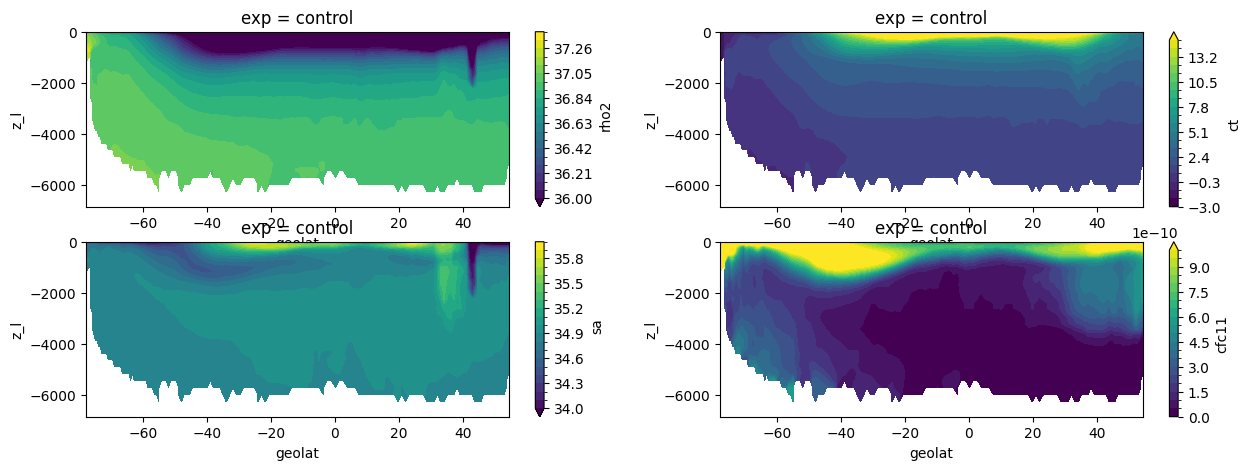

In [13]:
ds_zon_ts_tmp = combined_zon_ts_ds.sel(exp = "control")
fig, axes = plt.subplots(2, 2, figsize = (15, 5))
ax = axes.flatten()
ds_zon_ts_tmp.mean("time")["rho2"].T.plot.contourf(ax = ax[0],y = "z_l", x = "geolat", levels = 21, vmin = 36, vmax = 37.4)
ds_zon_ts_tmp.mean("time")["ct"].T.plot.contourf(ax = ax[1],y = "z_l", x = "geolat", levels = 21, vmax = 15, vmin = -3)
ds_zon_ts_tmp.mean("time")["sa"].T.plot.contourf(ax = ax[2],y = "z_l", x = "geolat", levels = 21, vmax = 36, vmin = 34)
ds_zon_ts_tmp.mean("time")["cfc11"].T.plot.contourf(ax = ax[3], y = "z_l", x = "geolat", levels = 21, vmax = 1e-9)

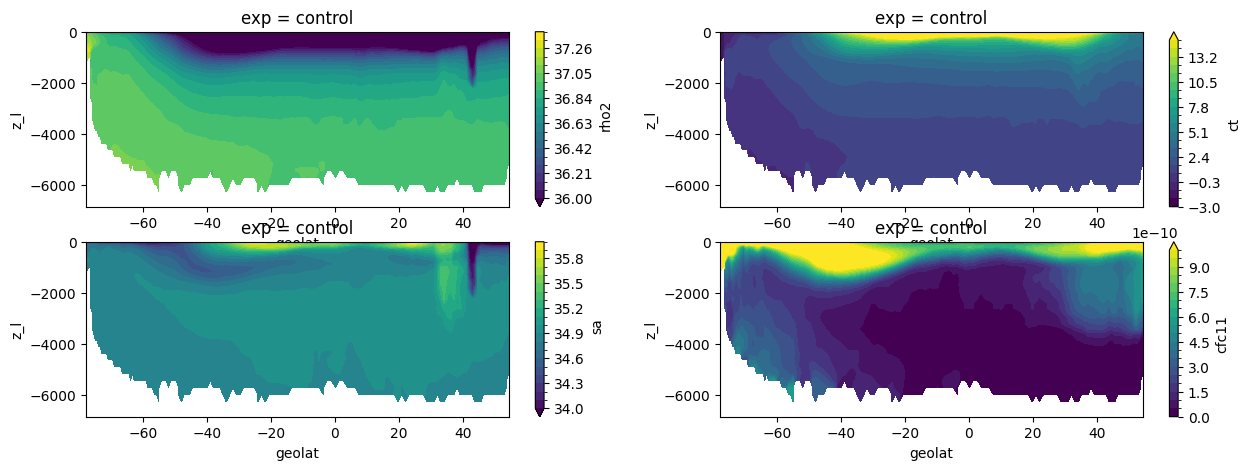

In [14]:
ds_zon_ts_tmp = combined_zon_ts_ds.sel(exp = "control")
fig, axes = plt.subplots(2, 2, figsize = (15, 5))
ax = axes.flatten()
ds_zon_ts_tmp.mean("time")["rho2"].T.plot.contourf(ax = ax[0],y = "z_l", x = "geolat", levels = 21, vmin = 36, vmax = 37.4)
ds_zon_ts_tmp.mean("time")["ct"].T.plot.contourf(ax = ax[1],y = "z_l", x = "geolat", levels = 21, vmax = 15, vmin = -3)
ds_zon_ts_tmp.mean("time")["sa"].T.plot.contourf(ax = ax[2],y = "z_l", x = "geolat", levels = 21, vmax = 36, vmin = 34)
ds_zon_ts_tmp.mean("time")["cfc11"].T.plot.contourf(ax = ax[3], y = "z_l", x = "geolat", levels = 21, vmax = 1e-9)

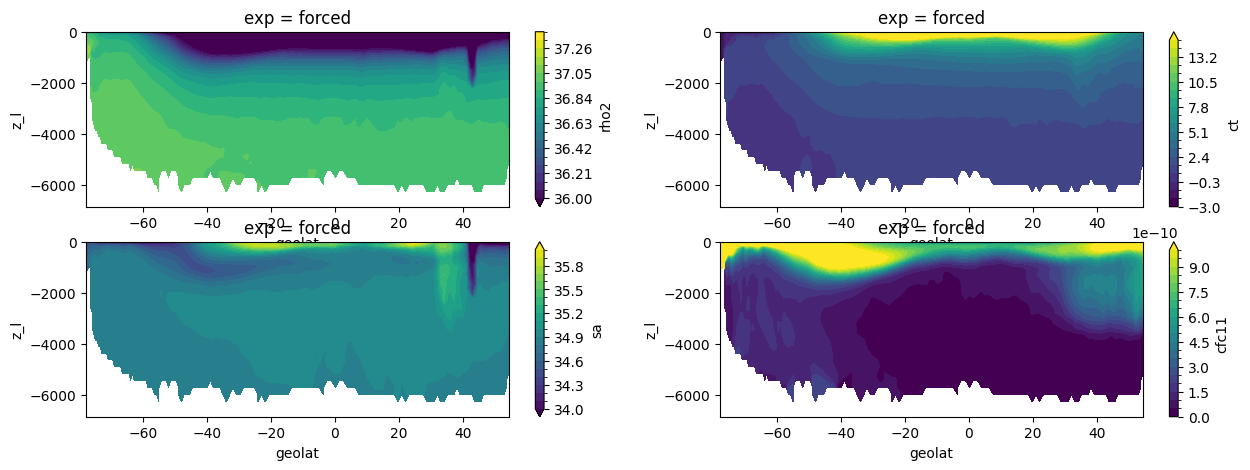

In [15]:
ds_zon_ts_tmp = combined_zon_ts_ds.sel(exp = "forced")
fig, axes = plt.subplots(2, 2, figsize = (15, 5))
ax = axes.flatten()
ds_zon_ts_tmp.mean("time")["rho2"].T.plot.contourf(ax = ax[0],y = "z_l", x = "geolat", levels = 21, vmin = 36, vmax = 37.4)
ds_zon_ts_tmp.mean("time")["ct"].T.plot.contourf(ax = ax[1],y = "z_l", x = "geolat", levels = 21, vmax = 15, vmin = -3)
ds_zon_ts_tmp.mean("time")["sa"].T.plot.contourf(ax = ax[2],y = "z_l", x = "geolat", levels = 21, vmax = 36, vmin = 34)
ds_zon_ts_tmp.mean("time")["cfc11"].T.plot.contourf(ax = ax[3], y = "z_l", x = "geolat", levels = 21, vmax = 1e-9)